## Metrics and SIgnatures for US models

### Overview

Models: 
- MTS-LSTM Era5 forcing, HydroMT statics (model 1A)
- MTS-LSTM NLDAS2 forcing, Camels US statics (model 2A)

Results
- Load test_results

Metrics:
- Load/Calculate peak metrics
- Load metrics and combine with peak metrics

Signatures:
- Load/Calcualte signatures

Comparison:
- Table with mean metrics and sigantures per model, per HRU, per cluster
- Corellation between signatures based on observed streamflow and modeled streamflow

### Imports etc

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot, scatter_matrix

import os
import pickle
from collections import defaultdict
from typing import List, Dict, Tuple
from tqdm.notebook import tqdm
from pathlib import Path

from scipy.stats import pearsonr

from neuralhydrology.evaluation.signatures import calculate_signatures, get_available_signatures
from neuralhydrology.evaluation.metrics import calculate_metrics

from peak_magnitude import mean_peak_magnitude


In [6]:
forcing_dir = 'data/time-series/'
mts_dir = ['data/results/03_era5_hydromt', 'data/results/01_nldas2_hydromt']

frequencies = ['1D', '1H']
models = ['US_mts_era5', 'US_mts_nldas'] # name for model runs to determine metrics and signatures for

start_date = pd.to_datetime('2008-10-01 00:00')
end_date = pd.to_datetime('2018-09-30 23:00')

### Load data
1. HRU
2. precipitation
3. model results (simulated Q timeseries): DICT[catchtm][freq]['xr']

In [7]:
# 516 CAMELS US catchments with hourly Qobs available
with open('data/516_basins.txt', 'r') as f:
    catchments = [line.rstrip() for line in f]
    f.close()
    
# 1. Load HRU associated with each catchment
huc_df = pd.read_csv('data/camels_attributes/camels_name.txt', header=0, dtype={'gauge_id': str, 'huc_02': str}, sep=';')
huc_df.index = huc_df.gauge_id
huc_df = huc_df.drop(columns=['gauge_id', 'gauge_name'])
huc_df = huc_df.loc[huc_df.index.isin(catchments)]
huc_df.index = huc_df.index.rename('catchment')

# 2. Load precipitation (required for calculation of runoff ratio and stream elasticity)
forcing_ds_era5 = xr.open_dataset(forcing_dir + 'era5_US_all.nc')
forcing_ds_era5 = forcing_ds_era5.drop_vars('spatial_ref')
precip_era5 = forcing_ds_era5.precip
precip_era5 = precip_era5.rename({'date': 'datetime'})

precip_nldas2 = xr.open_dataset(forcing_dir + 'usgs-streamflow-nldas_hourly.nc').total_precipitation
precip_nldas2 = precip_nldas2.rename({'date': 'datetime'})

# 3. model results (MTS-LSTM US)
mts_era5_results = pickle.load(open(mts_dir[0] + '/test_results.p', 'rb'))
mts_nldas2_results = pickle.load(open(mts_dir[1] + '/test_results.p', 'rb')) 

### MTS metrics and signatures
1. Load or calculate peak magnitude metrics
2. Load other metrics (NSE, KGE, FHV, Peak timing) and combine all emtrics in one dataframe

#### 1. Load or calculate peak MAGNITUDE metrics (abs and rel error)

In [8]:
repeat = False   # "True" to (re-)calculate peak metrics

if not os.path.isfile('data/results/final_runs_peak_metrics.p') or repeat:   
    results_dicts = [mts_era5_results, mts_nldas2_results]
    peak_metrics_dict = defaultdict(lambda: defaultdict(dict))
    
    for j, model in enumerate(models):
        results = results_dicts[j]
        metrics_df_hourly = pd.DataFrame()
        metrics_df_daily = pd.DataFrame()

        for freq in frequencies:
            print(f'Calculating metrics for model {model}, based on {freq} results. \
                  Takes long, especially for hourly results.')
            if freq =='1D':
                metrics_df = metrics_df_daily
            if freq == '1H':
                metrics_df = metrics_df_hourly

            for i, catchment in enumerate(catchments):
                if i % 50 == 0:
                    print(i)
                    
                # get streamflow results for catchment
                ds = results[catchment][freq]['xr']

                # resample timestep
                if freq == '1H':
                    ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                    ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                    ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
                elif freq == '1D':
                    ds = ds.isel(time_step = -1)
                    ds = ds.drop('time_step')
                    ds = ds.rename({'date': 'datetime'})

                if j == 0:
                    var_obs = 'qobs_obs'
                    var_sim = 'qobs_sim'
                elif j ==1:
                    var_obs = 'qobs_mm_per_hour_obs'
                    var_sim = 'qobs_mm_per_hour_sim'

                # get observed streamflow
                qobs = ds[var_obs] * (24 if freq == '1D' else 1)

                # get simulated streamflow
                qsim = ds[var_sim] * (24 if freq == '1D' else 1)

                # Calculate peak metrics
                values = mean_peak_magnitude(qobs, qsim, resolution=freq)
                df_temp = pd.DataFrame(data=values, 
                                       columns=['abs_error', 'rel_error', 'peaks', 'sim<obs', 'sim>obs'],
                                       index=[catchment])
                metrics_df = metrics_df.append(other=df_temp)

            peak_metrics_dict[model][freq] = metrics_df
      
    # save nested dict to local drive
    pickle.dump({k: dict(v) for k, v in peak_metrics_dict.items()}, Path('data/results/final_runs_peak_metrics.p').open('wb'))
else:
    # load from local drive
    print(f'Loading peak metrics for all models from drive.')
    peak_metrics_dict = pickle.load(Path('data/results/final_runs_peak_metrics.p').open('rb'))  

# peak_metrics_dict['US_mts_era5']['1D']

Loading peak metrics for all models from drive.


#### 2. Load other metrics, combine with peak magnitude metrics, create multiindex df
- metrics are already computed after training when evaluating on test period (MTS-LSTM_train_test.ipynb)
- combine with HUC
- combine with cluster (from clustering on catchment charactersitics) -->  multiindex df

In [12]:
#  results dataframe metrics
results_df_m = pd.DataFrame()
name = ['era5', 'nldas2']


for i, model in enumerate(models):
    # load metrics
    mts_metrics_d = pickle.load(Path(mts_dir[i] + '/metrics_df_daily.pkl').open('rb'))
    mts_metrics_h = pickle.load(Path(mts_dir[i] + '/metrics_df_hourly.pkl').open('rb'))
    peak_metrics_d = peak_metrics_dict[model]['1D']
    peak_metrics_h = peak_metrics_dict[model]['1H']

    mts_metrics_d.index.rename('catchment')
    mts_metrics_h.index.rename('catchment')
    peak_metrics_d.index.rename('catchment')
    peak_metrics_h.index.rename('catchment')
    
    # combine metrics with peak magnitude metrics 
    mts_metrics_d = huc_df.join(mts_metrics_d, on='catchment', how='inner')
    mts_metrics_d = mts_metrics_d.join(peak_metrics_d, on='catchment', how='inner')
    mts_metrics_h = huc_df.join(mts_metrics_h, on='catchment', how='inner')
    mts_metrics_h = mts_metrics_h.join(peak_metrics_h, on='catchment', how='inner')
    
    # add 'CLuster' column to metrics_df
    with open('data/basins_in_cluster_camels.p', 'rb') as f:
        clusters = pickle.load(f)

    mts_metrics_d['Cluster'] = 0
    mts_metrics_h['Cluster'] = 0
    for key, item in clusters[7].items():
        mts_metrics_d['Cluster'].loc[mts_metrics_d.index.isin(item)] = int(key) 
        mts_metrics_h['Cluster'].loc[mts_metrics_h.index.isin(item)] = int(key) 
    
    # create multiindex
    mts_metrics_d = pd.concat({'1D': mts_metrics_d}, names=['freq']) 
    mts_metrics_d = pd.concat({model: mts_metrics_d}, names=['model'])
    mts_metrics_h = pd.concat({'1H': mts_metrics_h}, names=['freq']) 
    mts_metrics_h = pd.concat({model: mts_metrics_h}, names=['model'])

    results_df_m = pd.concat([results_df_m, mts_metrics_d, mts_metrics_h])

# results_df_m

C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Calculate Signatures

In [13]:
signature_unit_dict = {'high_q_freq': 'd/a',
                         'high_q_dur': 'd',
                         'low_q_freq': 'd/a',
                         'low_q_dur': 'd',
                         'zero_q_freq': 'd/a',
                         'q95': 'mm/d',
                         'q5': 'mm/d',
                         'q_mean': 'mm/d',
                         'hfd_mean': 'd',
                         'slope_fdc': '',
                         'stream_elas': '',
                         'runoff_ratio': '-',}

all_signatures = get_available_signatures()
all_signatures.remove('baseflow_index')

all_signatures

['high_q_freq',
 'high_q_dur',
 'low_q_freq',
 'low_q_dur',
 'zero_q_freq',
 'q95',
 'q5',
 'q_mean',
 'hfd_mean',
 'slope_fdc',
 'stream_elas',
 'runoff_ratio']

In [15]:
repeat = False    # "True" to (re-)calculate signatures

if not os.path.isfile('data/results/US_signatures.p') or repeat==True:  
    US_signatures = defaultdict(lambda: defaultdict(dict))
    results_dicts = [mts_era5_results, mts_nldas2_results]
    precipitations = [precip_era5, precip_nldas2]

    for j, model in enumerate(models):
        results = results_dicts[j]
        precip = precipitations[j]
        
        for freq in frequencies:
            print(f'Calculating signatures for model {model}, based on {freq} results. \
                  Takes long, especially for hourly results.')
            for i, catchment in enumerate(catchments):
                
                # resample precipitation
                if freq == '1D':
                    f_precip = xr.DataArray(precip.sel(basin=catchment).to_series().resample('1D').sum())
                elif freq == '1H':
                    f_precip = precip.sel(basin=catchment)
                f_precip = f_precip.sel(datetime=slice(start_date, end_date))
                
                # get streamflow results for catchment
                ds = results[catchment][freq]['xr']

                # resample timestep
                if freq == '1H':
                    ds['time_step'] = pd.to_timedelta(ds.time_step.values, unit='hours')
                    ds = ds.isel(time_step=slice(-24, None)).stack(datetime=['date', 'time_step'])
                    ds['datetime'] = ds.coords['date'] + ds.coords['time_step']
                elif freq == '1D':
                    ds = ds.isel(time_step = -1)
                    ds = ds.drop('time_step')
                    ds = ds.rename({'date': 'datetime'})

                if j == 0:
                    var_obs = 'qobs_obs'
                    var_sim = 'qobs_sim'
                elif j ==1:
                    var_obs = 'qobs_mm_per_hour_obs'
                    var_sim = 'qobs_mm_per_hour_sim'

                # calculate signatures (for observed streamflow once with era5, once with nldas2 precipitation)
                # get observed streamflow
                qobs = ds[var_obs] * (24 if freq == '1D' else 1) # convert mm/h to mm (or mm/d?)
                US_signatures['obs_' + model][catchment][freq] = calculate_signatures(qobs, all_signatures + ['baseflow_index'],
                                                                               datetime_coord='datetime',
                                                                               prcp=f_precip)

                # get simulated streamflow
                qsim = ds[var_sim] * (24 if freq == '1D' else 1)

                # calculate signatures
                US_signatures[model][catchment][freq] = calculate_signatures(qsim, all_signatures, 
                                                                         datetime_coord='datetime',
                                                                         prcp=f_precip)
                
                # for baseflow index calculation, mask the array in the same places where obs has NaNs.
                masked_sim = qsim.copy()
                masked_sim[qobs.isnull()] = np.nan
                US_signatures[model][catchment][freq]['baseflow_index'] = \
                    calculate_signatures(masked_sim, ['baseflow_index'], datetime_coord='datetime')['baseflow_index']
                
                if i % 50 == 0 or i == 515:
                    print(i)

    # save nested dict to local drive
    pickle.dump({k: dict(v) for k, v in US_signatures.items()}, Path('data/results/US_signatures.p').open('wb'))

else:
    # load from local drive
    print(f'Loading signatures for all models from drive.')
    US_signatures = pickle.load(Path('data/results/US_signatures.p').open('rb'))  

US_signatures.keys()

Loading signatures for all models from drive.


dict_keys(['obs_US_mts_era5', 'US_mts_era5', 'obs_US_mts_nldas', 'US_mts_nldas'])

### Show metrics & signatures in table 

#### convert dictionarries with metrics and signatures to dataframes

In [16]:
def dict_to_df(model: str, results: dict, freqs: List[str]) -> pd.DataFrame:
    """Convert a nested dict into a MultiIndex DataFrame. """
    results = results[model].copy()
    for catchm in results.keys():
        for freq in freqs:
            keys = list(results[catchm][freq].keys())
            for key in keys:
                results[catchm][freq][key] = results[catchm][freq].pop(key)
    df = pd.DataFrame.from_dict({(model, catchm, freq): results[catchm][freq]
                                 for catchm in results.keys() 
                                 for freq in freqs},
                                orient='index')
    df = df.swaplevel(1, 2, axis=0)
    df.index.rename(['model', 'freq', 'catchment'], inplace=True)
    return df

In [17]:
# create multiindex [model, freq, catchment] dataframe with metrics and one with signatures combined for all models

# metrics combined df (is already a df)
results_df_m

# signatures combined df
results_df_s = pd.concat([dict_to_df(model_name, US_signatures, frequencies)
                       for model_name in US_signatures.keys()]).sort_index()

In [19]:
# combine signature df with huc_df, create multiindex df

results_df_s_huc = pd.DataFrame()

for model in results_df_s.index.get_level_values('model').unique():
    for freq in frequencies:
        a = huc_df.join(results_df_s.loc[(model, freq)], on='catchment', how='inner')    
        a = pd.concat({freq: a}, names=['freq']) 
        a = pd.concat({model: a}, names=['model'])
        results_df_s_huc = pd.concat([results_df_s_huc, a])
# results_df_s_huc

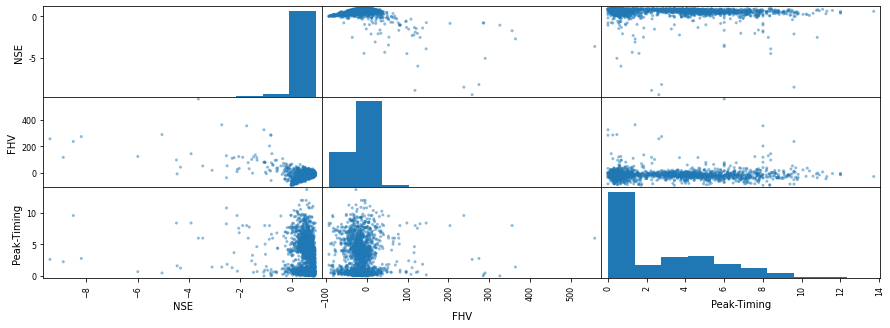

In [20]:
# results_df_m
scatter_matrix(results_df_m[['NSE', 'FHV', 'Peak-Timing']], figsize=(15, 5), diagonal='hist'); # diagonal='kde'

#### show table to compare metrics and signatures (median per model)

In [26]:
drop_cols = ['Alpha-NSE', 'Beta-NSE', 'MSE', 'RMSE', 'Pearson-r', 'FMS', 'FLV']
# metrics

# group by model
medians_m = results_df_m.groupby(['model', 'freq']).median()
medians_m['NSE_mean'] = results_df_m['NSE'].groupby(['model', 'freq']).mean()
medians_m['NSE<0'] = results_df_m['NSE'].groupby(['model', 'freq']).apply(lambda x: (x<0).sum())
medians_m['KGE<-0.41'] = results_df_m[['KGE']].groupby(['model', 'freq']).apply(lambda x: (x<-0.41).sum())
medians_m.drop(columns=drop_cols, inplace=True)

# group by HUC
medians_huc_m = results_df_m.groupby(['huc_02', 'model', 'freq']).median()
medians_huc_m['NSE_mean'] = results_df_m[['NSE', 'huc_02']].groupby(['huc_02', 'model', 'freq']).mean()
medians_huc_m['NSE<0'] = results_df_m[['NSE', 'huc_02']].groupby(['huc_02', 'model', 'freq']).apply(lambda x: (x<0).sum())
medians_huc_m['KGE<-0.41'] = results_df_m[['KGE', 'huc_02']].groupby(['huc_02', 'model', 'freq']).apply(lambda x: (x<-0.41).sum())
medians_huc_m.drop(columns=drop_cols, inplace=True)


# group by cluster
medians_cluster_m = results_df_m.groupby(['Cluster', 'model', 'freq']).median()
medians_cluster_m['NSE_mean'] = results_df_m[['NSE', 'Cluster']].groupby(['Cluster', 'model', 'freq']).mean()
# medians_cluster_m['NSE<0'] = results_df_m[['NSE', 'Cluster']].groupby(['Cluster', 'model', 'freq']).apply(lambda x: (x<0).sum())
# medians_cluster_m['KGE<-0.41'] = results_df_m[['KGE', 'Cluster']].groupby(['Cluster', 'model', 'freq']).apply(lambda x: (x<-0.41).sum())
medians_cluster_m.drop(columns=drop_cols, inplace=True)


print('Median metrics per model over all US catchments:')
display(medians_m.style.format('{:.2f}'))

print('Median metrics per model and HUC:')
display(medians_huc_m.style.format('{:.2f}'))

print('Median metrics per model and HUC:')
display(medians_cluster_m.style.format('{:.2f}'))


Median metrics per model over all US catchments:


Median metrics per model and HUC:


Median metrics per model and HUC:


In [27]:
metrics_dict = {'Model_median': medians_m,
               'per_HUC': medians_huc_m,
               'per_cluster': medians_cluster_m}

with open('data/results/metrics_tables_US.p', 'wb') as f:  
    pickle.dump(metrics_dict, f, protocol=pickle.DEFAULT_PROTOCOL)

In [31]:
keep_cols = ['high_q_freq', 'high_q_dur', 'q95', 'hfd_mean', 'runoff_ratio']
# signatures

# group by model and freq
medians_s = results_df_s_huc.groupby(['model', 'freq']).median()
medians_huc_s = results_df_s_huc.groupby(['huc_02', 'model', 'freq']).median()

# group by huc
medians_huc_s = results_df_s_huc.groupby(['huc_02', 'model', 'freq']).median()
medians_huc_s = medians_huc_s[keep_cols]

# hfd mean from hours to days
medians_s.loc[pd.IndexSlice[:, '1H'], 'hfd_mean'] = medians_s.loc[pd.IndexSlice[:, '1H'], 'hfd_mean'] / 24
medians_huc_s.loc[pd.IndexSlice[:, :, '1H'], 'hfd_mean'] = medians_huc_s.loc[pd.IndexSlice[:, :, '1H'], 'hfd_mean'] / 24

print('Median signatures per model over all US catchments:')
display(medians_s.style.format('{:.3f}'))

print('Median signatures per model and HUC:')
display(medians_huc_s.style.format('{:.3f}'))


Median signatures per model over all US catchments:


Median signatures per model and HUC:


Median signatures per model and cluster:


#### Correlation between signatures of simulated streamflow and signatures of observed streamflow

In [32]:
signature_corr = pd.DataFrame(index=frequencies, columns=results_df_s.columns, dtype=float)
signature_corr.index.rename('freq', inplace=True)
signature_corr = pd.concat({models[-1]: signature_corr}, names=['model'])
signature_corr.loc[(models[0], frequencies[0]),:] = np.full([1, len(signature_corr.columns)], np.nan).tolist()[0]
signature_corr.loc[(models[0], frequencies[1]),:] = np.full([1, len(signature_corr.columns)], np.nan).tolist()[0]

for freq in frequencies:
    for model in models:
        for sig in signature_corr.columns:
            name_obs = 'obs_'+model
            sig_obs = results_df_s.loc(axis=0)[name_obs, freq][sig].sort_index()
            sig_sim = results_df_s.loc(axis=0)[model, freq][sig].reindex(sig_obs.index)
            mask = ~(pd.isna(sig_obs) | pd.isna(sig_sim))
            if mask.sum() ==0:
                continue
            signature_corr.loc(axis=0)[model, freq][sig] = pearsonr(sig_obs[mask].values, sig_sim[mask].values)[0]

display(signature_corr.style.format('{:.3f}'))

C:\Users\wilbrand\Miniconda3\envs\myenv\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
